# ShapeNet

## Dataset

In [1]:
import torch
from torch import nn
from torch import optim
import os
import os.path as osp

import pytorch_lightning as pl
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader

from pytorch_lightning.loggers import WandbLogger

In [2]:
category = 'Airplane'  # Pass in `None` to train on all categories.
path = osp.realpath(osp.join('..', 'data', 'ShapeNet'))

pre_transform, transform = T.NormalizeScale(), T.FixedPoints(400)
test_dataset = ShapeNet(path, category, split='test', transform=transform, pre_transform=pre_transform)
test_dataset = test_dataset[0:20]
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=6)

In [ ]:
from hpcs.utils.viz import plot_cloud

In [ ]:
cloud = test_dataset.get(0)

In [ ]:
# data.x contains points features extracted after having applied the transform
# data.pos contains the points coordinates
plotter = plot_cloud(cloud.pos.numpy(), scalars=cloud.y.numpy(), point_size=3.0, notebook=True)

## Model

In [3]:
import wandb
import yaml
from test import configure

In [4]:
os.remove(os.path.join(os.getcwd(), 'config.yaml'))

In [5]:
os.remove(os.path.join(os.getcwd(), 'model.ckpt'))

In [6]:
config_yaml = wandb.restore(name='config.yaml', run_path='pierreoo/HPCS/runs/2msnc6p8')
config = yaml.load(config_yaml, Loader=yaml.FullLoader)

In [7]:
model, trainer = configure(config)

C:\Users\olvcp\anaconda3\envs\hyperbolic\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'nn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nn'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Distributed:  False
Gpu:  0


In [8]:
wandb.restore('model.ckpt', run_path='pierreoo/HPCS/runs/2msnc6p8')
model = model.load_from_checkpoint('model.ckpt')
print(model)

SimilarityHypHC(
  (model): DGCNN(
    (conv1): DynamicEdgeConv(nn=MLP(6, 64, 64), k=10)
    (conv2): DynamicEdgeConv(nn=MLP(128, 64, 64), k=10)
    (conv3): DynamicEdgeConv(nn=MLP(128, 64, 2), k=10)
  )
  (triplet_loss): TripletHyperbolicLoss(
    (distance): LpDistance()
    (reducer): MeanReducer()
    (distace_sim): CosineSimilarity()
    (loss_triplet_sim): TripletMarginLoss(
      (distance): CosineSimilarity()
      (reducer): AvgNonZeroReducer()
    )
    (distance_lca): PoincareBall()
  )
)


Testing: 0it [00:00, ?it/s]

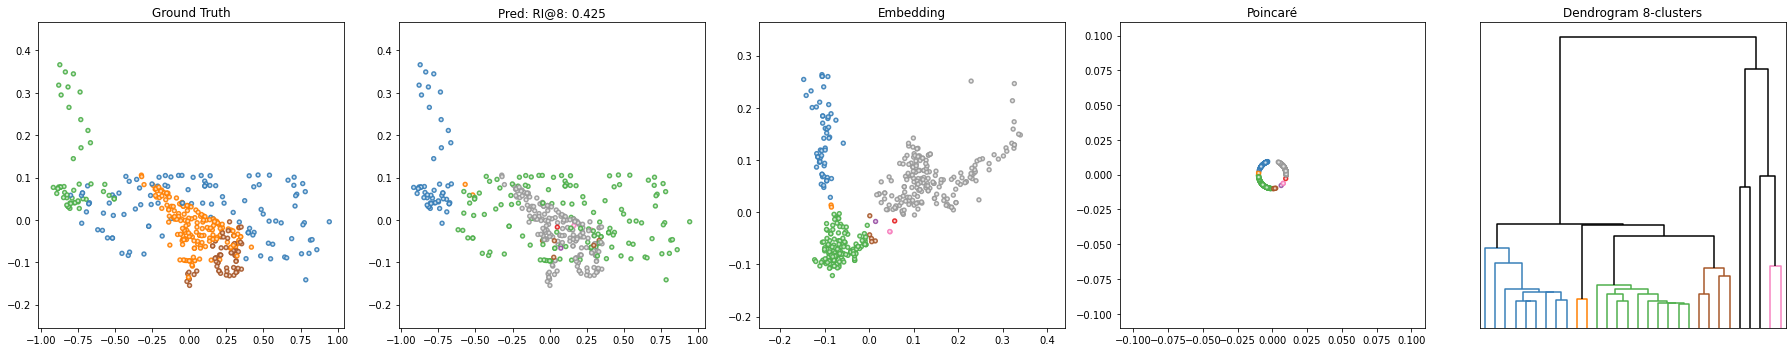

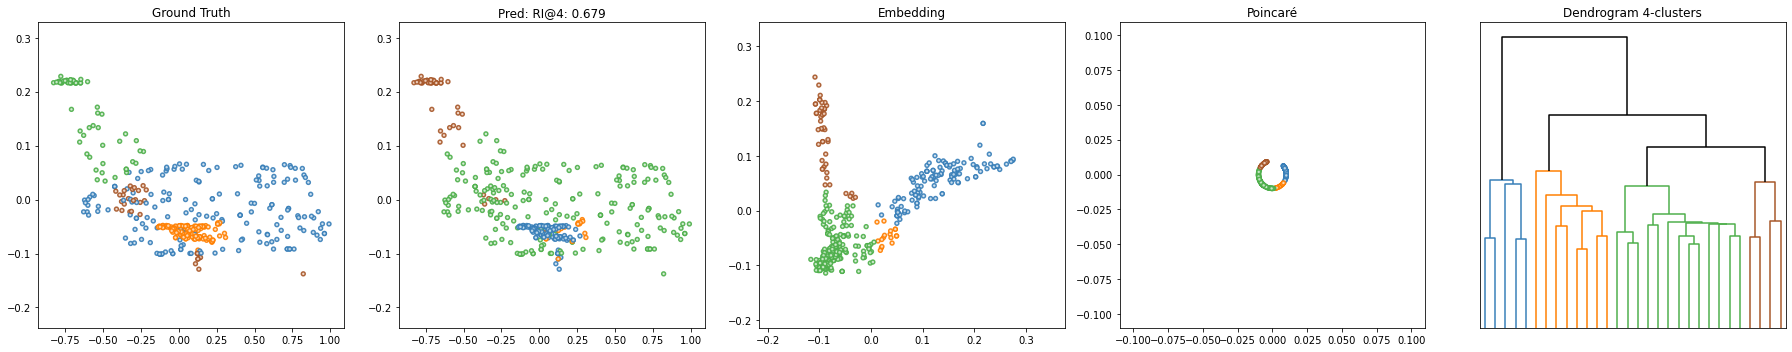

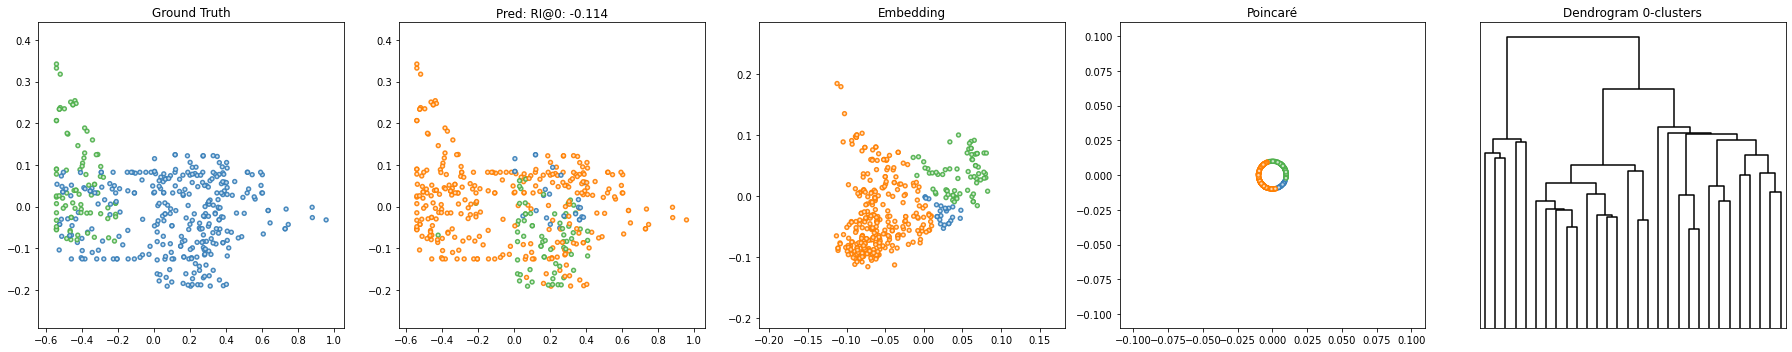

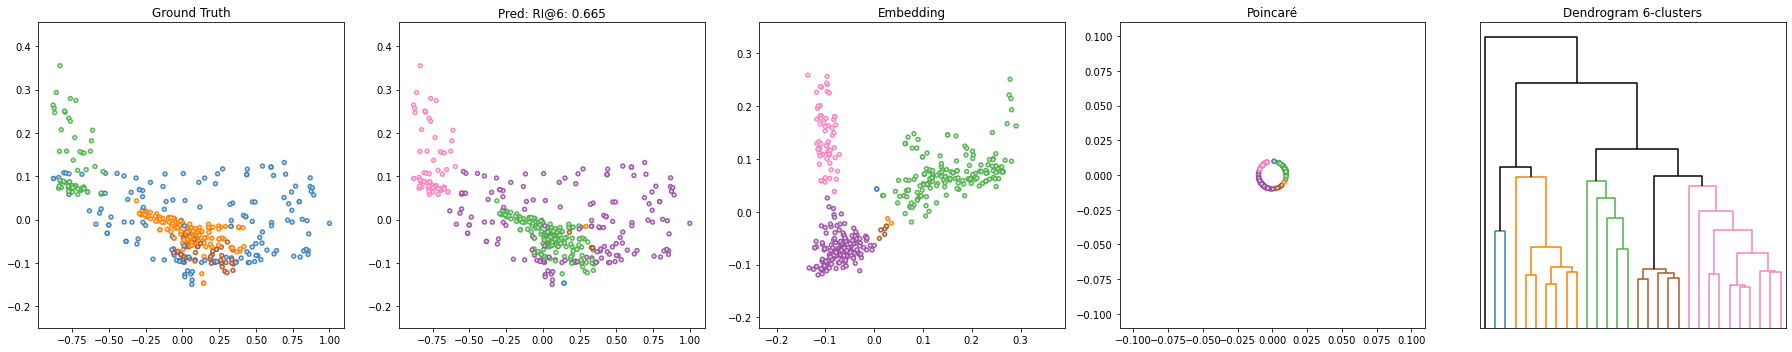

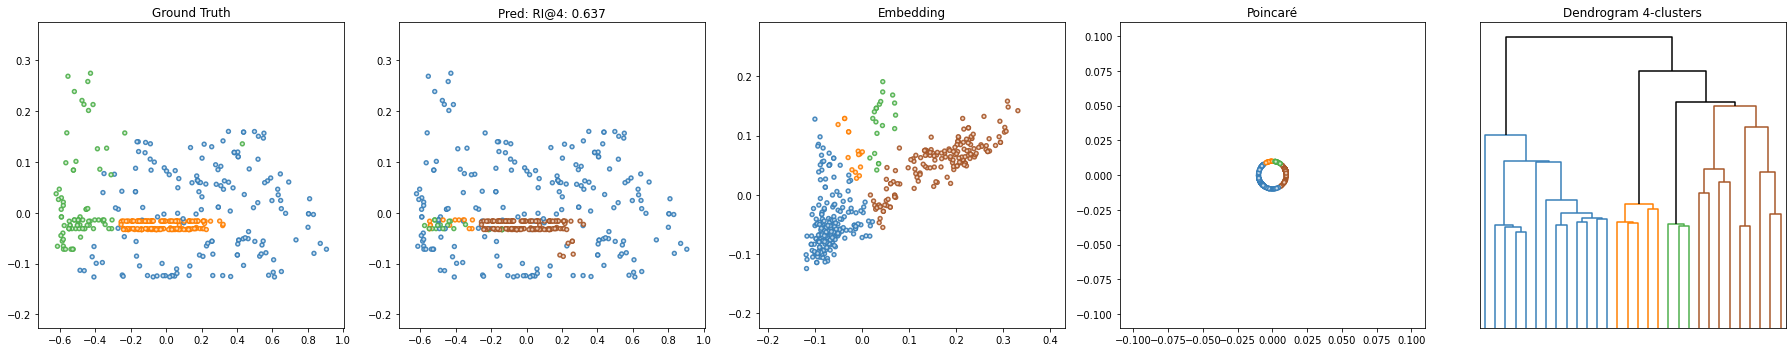

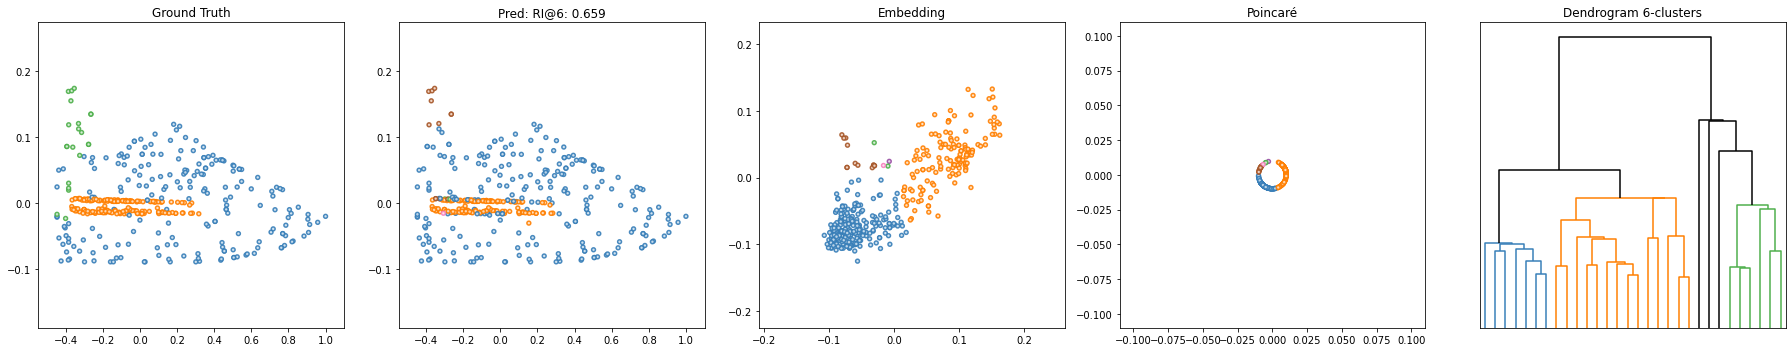

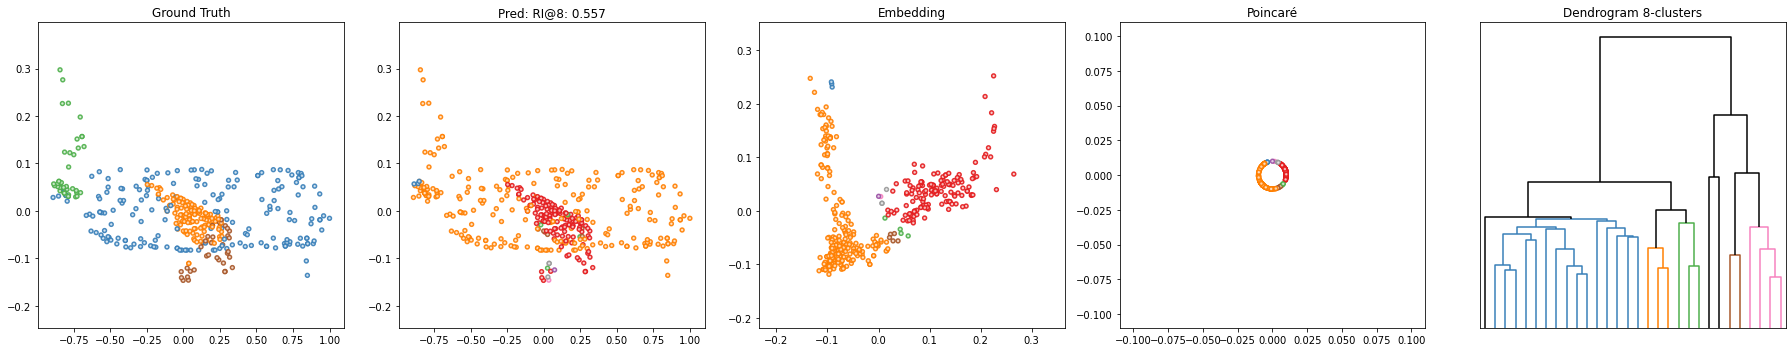

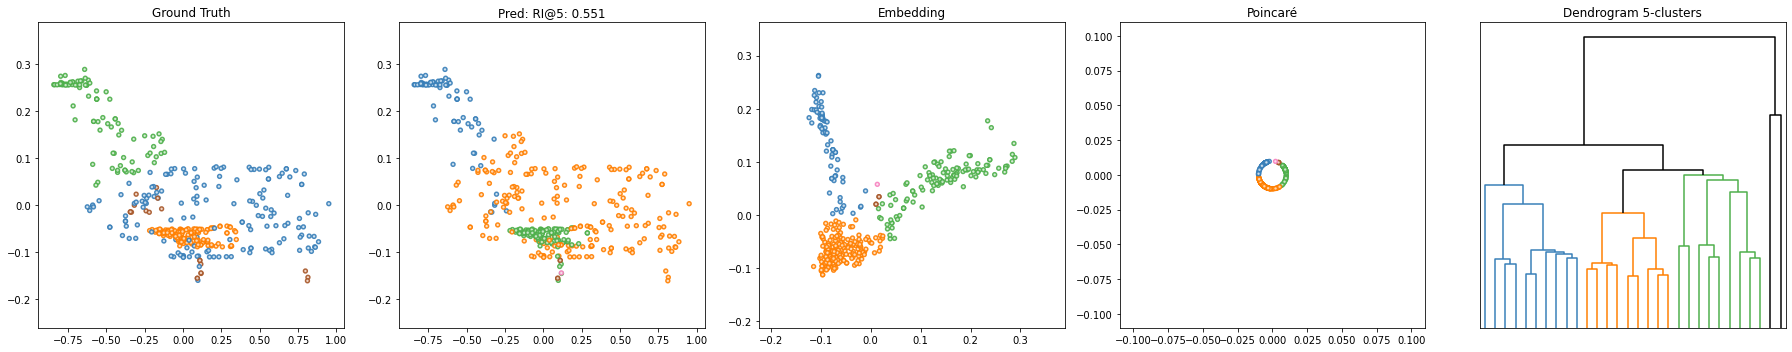

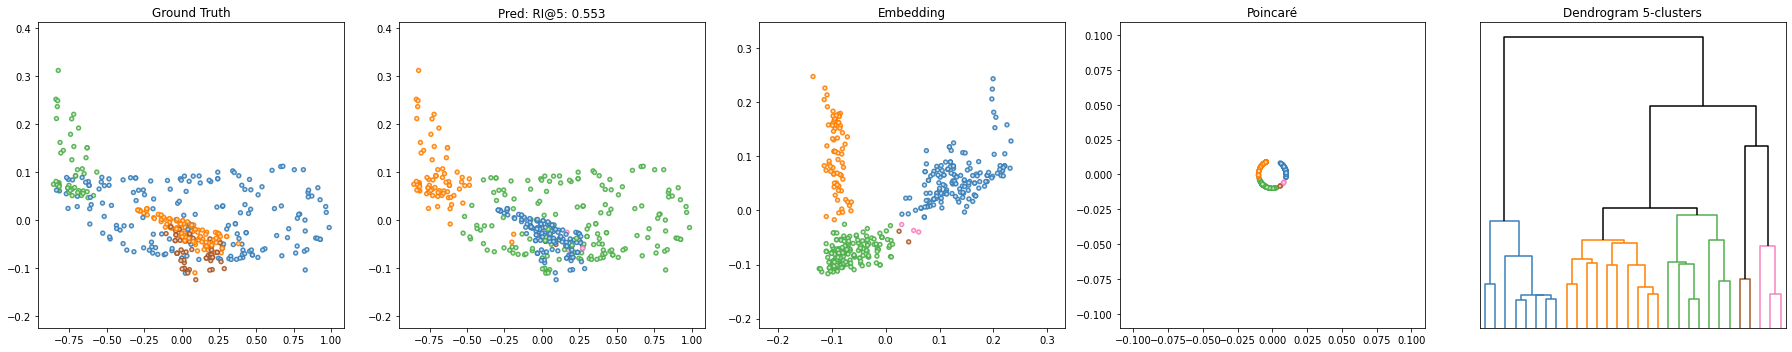

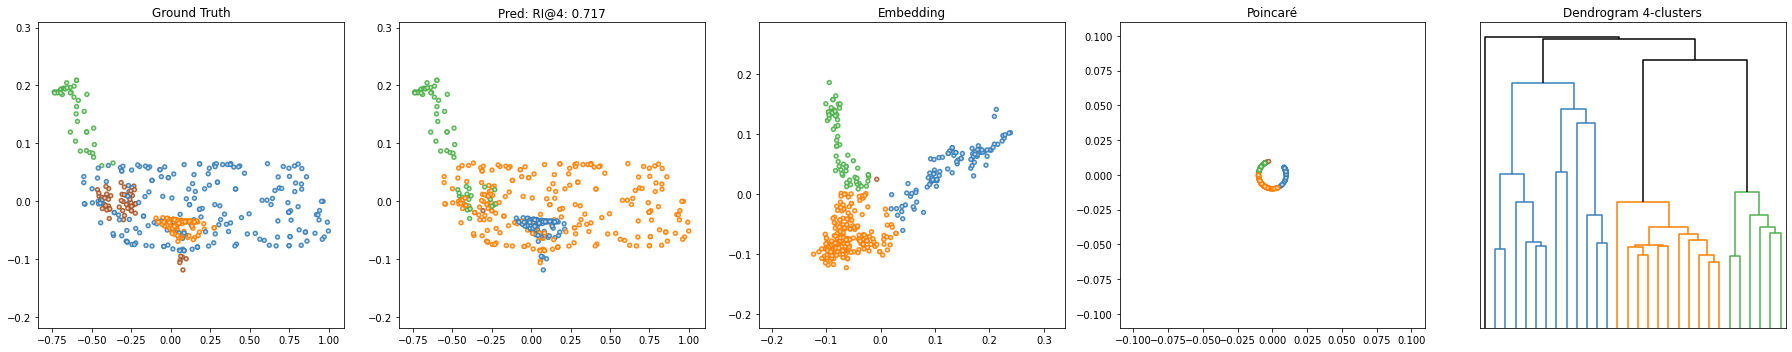

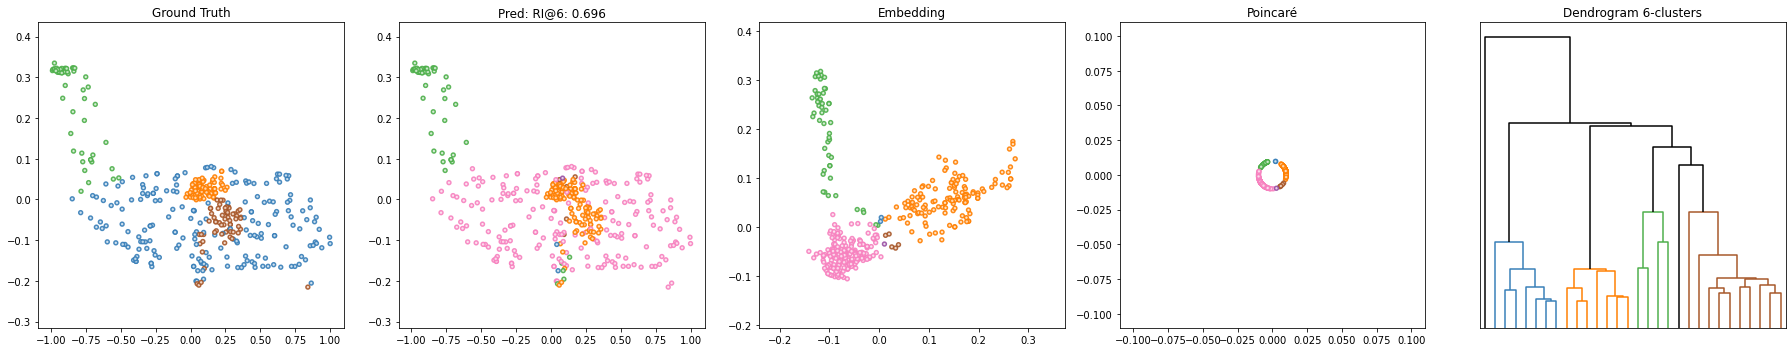

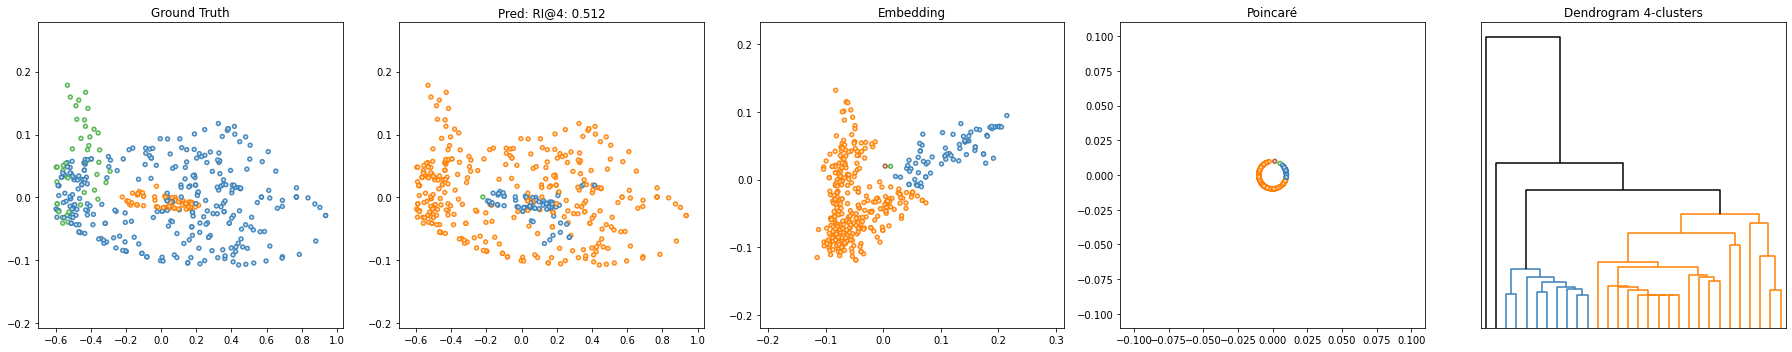

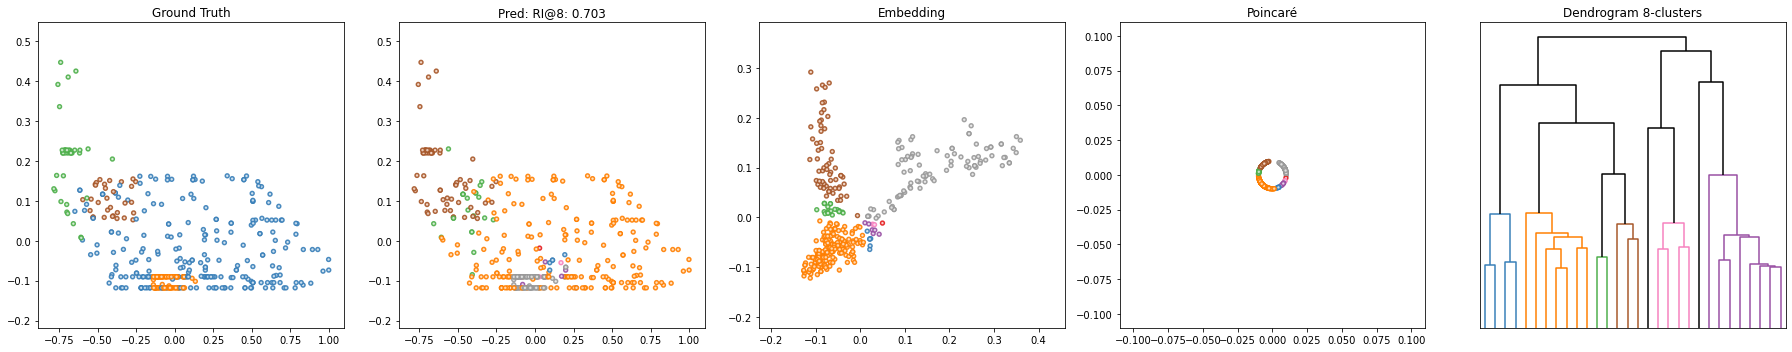

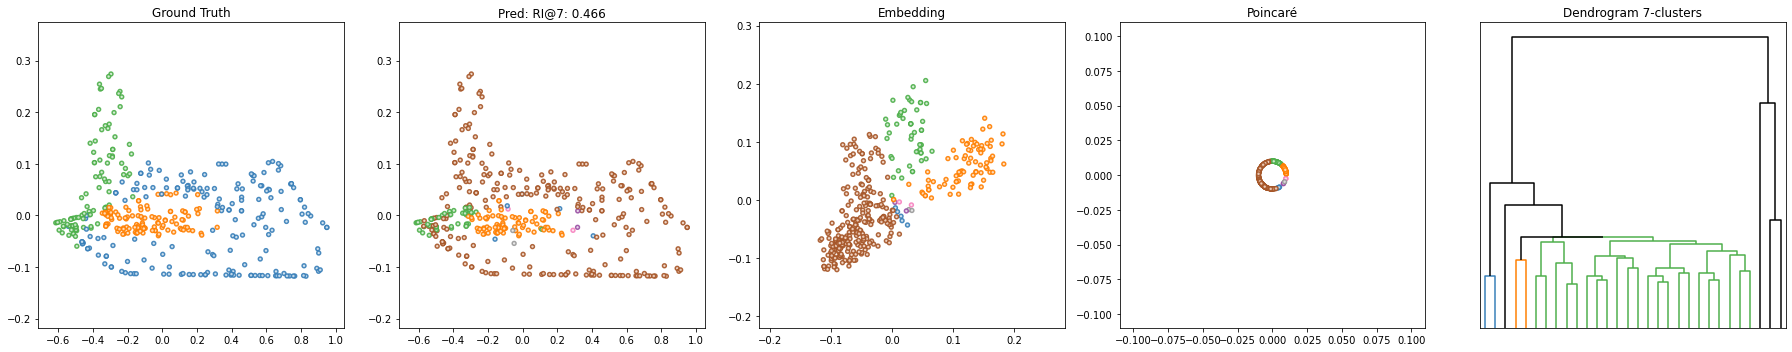

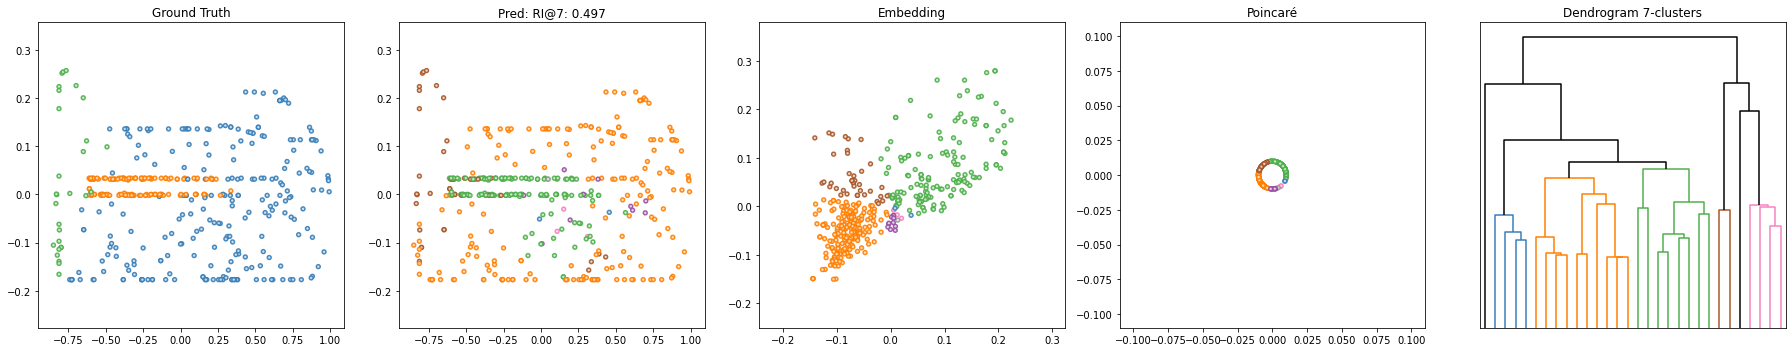

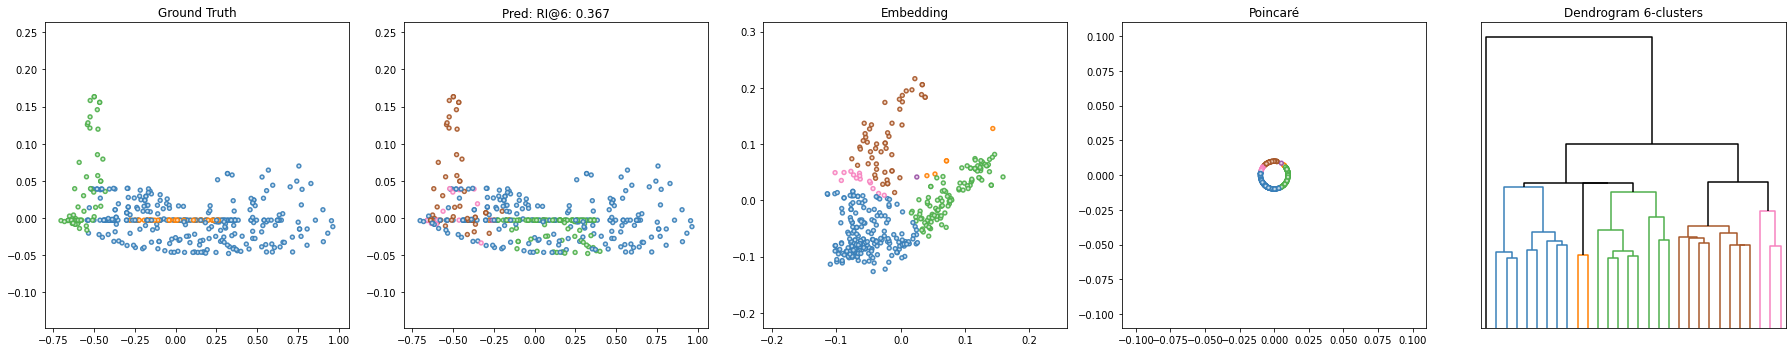

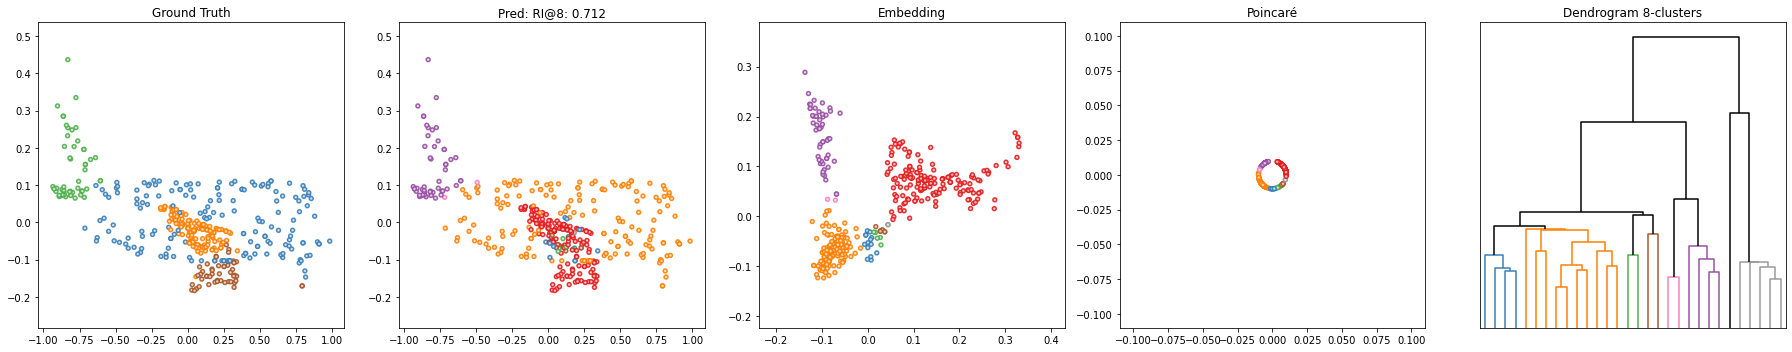

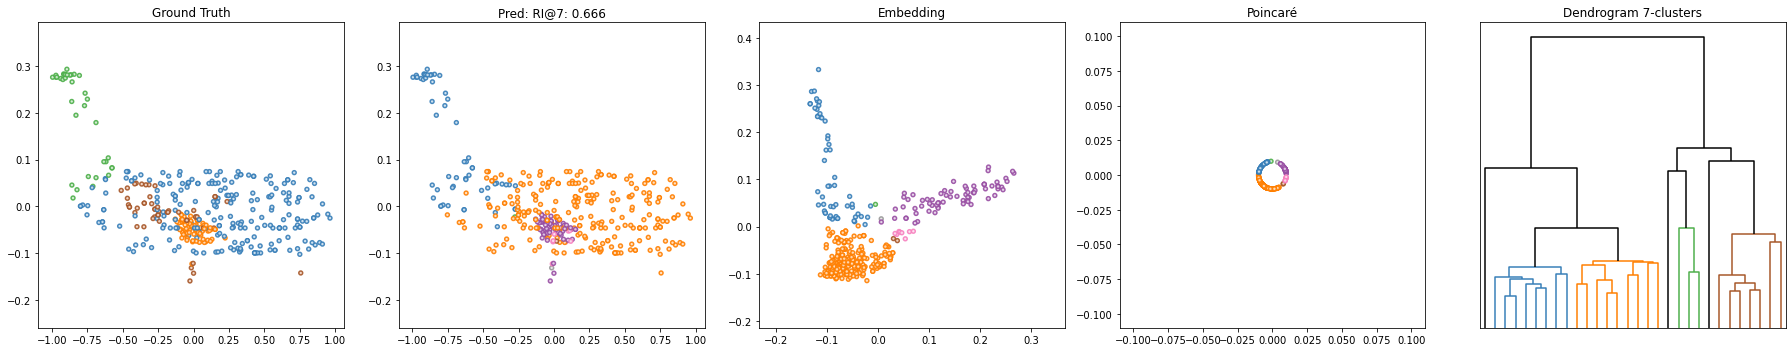

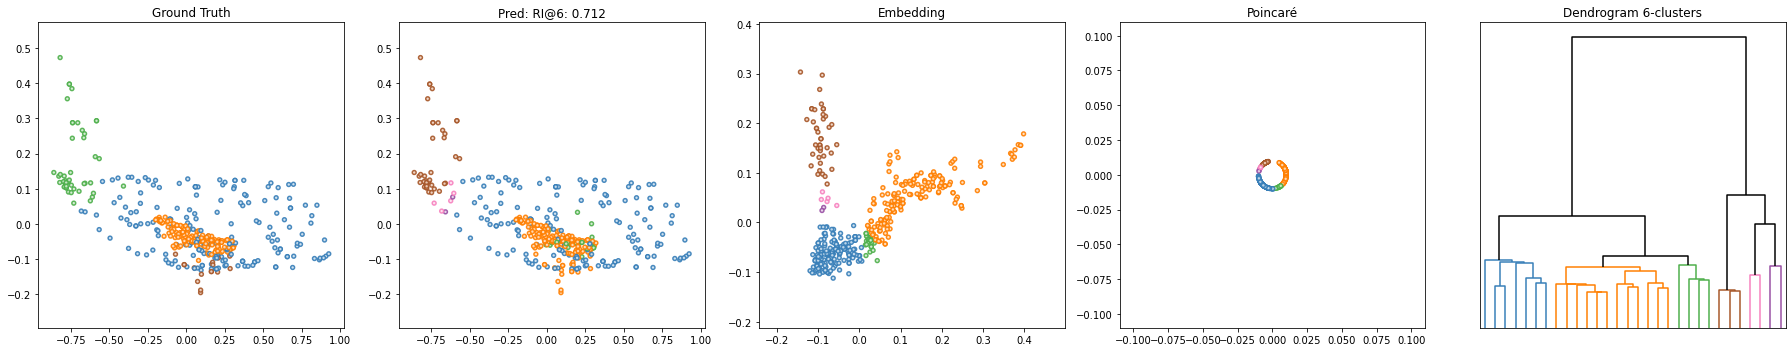

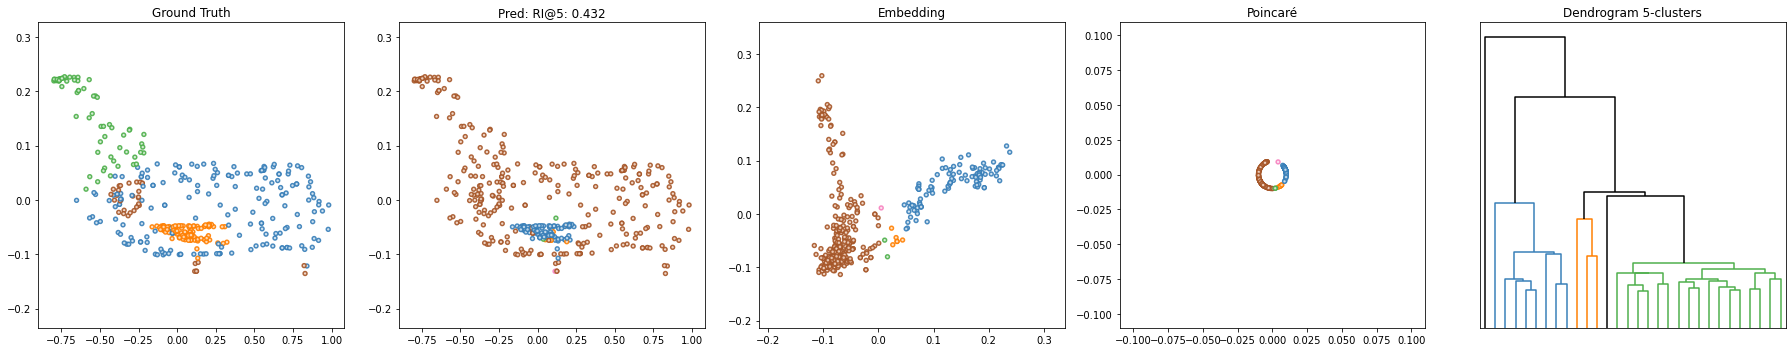

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.41900634765625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.41900634765625}]

In [10]:
trainer.test(model, test_loader)